## Imitative Learning: IL in continuous action space

模仿学习：连续动作空间

模拟数据集中的动作,就是传统的深度学习而已

In [49]:
import torch

# 封装数据集
class Dataset(torch.utils.data.Dataset):
  
  def __init__(self):
    import numpy as np
    data = np.loadtxt('continuous_act.txt')
    self.state = torch.FloatTensor(data[:, :3])
    self.action = torch.FloatTensor(data[:, -1]).reshape(-1, 1)
    
  def __len__(self):
    return len(self.state)
  
  def __getitem__(self, i):
    return self.state[i], self.action[i]
  
dataset = Dataset()
len(dataset), dataset[0]

(20000, (tensor([ 0.4413,  0.8974, -0.7139]), tensor([-1.0650])))

In [50]:
# 数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=8, shuffle=True, drop_last=True)
len(loader), next(iter(loader))

(2500,
 [tensor([[-0.9830,  0.1837, -8.0000],
          [ 0.8635,  0.5043, -2.2452],
          [ 0.9721,  0.2344, -0.0878],
          [ 0.9717,  0.2363,  0.1394],
          [ 0.9749,  0.2226, -0.0159],
          [ 0.4976, -0.8674,  5.9369],
          [ 0.9990, -0.0449, -1.5520],
          [ 0.8682,  0.4962, -2.3543]]),
  tensor([[-0.9551],
          [-0.3260],
          [-0.5088],
          [-0.6730],
          [-0.0062],
          [-1.3066],
          [ 0.3254],
          [-0.3072]])])

In [51]:
# 定义模型
model = torch.nn.Sequential(
  torch.nn.Linear(3, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 1),
  torch.nn.Tanh(),
)

model(torch.randn(2, 3)).shape

torch.Size([2, 1])

In [52]:
# 训练
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
  loss_fn = torch.nn.MSELoss()
  
  for epoch in range(10):
    for i, (state, action) in enumerate(loader):
      out = model(state)
      
      loss = loss_fn(out, action)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
    if epoch % 1 == 0:
      print(epoch, loss.item())
      
train()

0 0.08466440439224243
1 0.049497224390506744
2 0.0464479997754097
3 0.055240996181964874
4 0.09435778856277466
5 0.09823344647884369
6 0.012770024128258228
7 0.045108359307050705
8 0.03925003856420517
9 0.0412198081612587


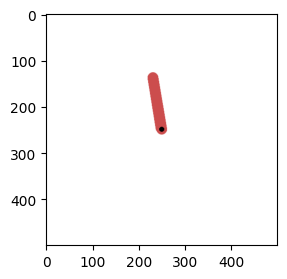

In [53]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step([action * 2])
    over = terminated or truncated

    # 偏移reward, 便于训练
    reward = (reward + 8) / 8
    
    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [54]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    action = model(torch.FloatTensor(state).reshape(1, 3)).item()
  
    # 增加噪声，增加探索
    action += random.normalvariate(mu=0, sigma=0.2)  

    state, reward, over = env.step(action)
    reward_sum += reward

    if show:
      display.clear_output(wait=True)
      env.show()

  return reward_sum

# 测试
sum([play() for _ in range(20)]) / 20

145.42952961886095

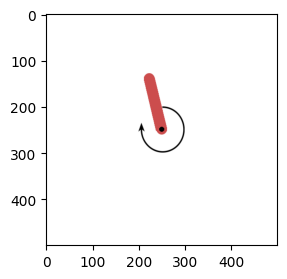

198.53143476954068

In [55]:
play(True)